## Description:

    Evaluate community differences between treated seeds and untreated controlls



# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)

library(tidyr)
library(vegan)
library(DESeq2)
library(phyloseq)
library(lmerTest)
library(lsmeans)
library(dplyr)

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: permute

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/home/br

In [3]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

library(RColorBrewer)
TreatmentColors = brewer.pal(3, 'Dark2')

# Loading phyloseq object

In [4]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [5]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

physeq = transform_sample_counts(physeq, function(x) sqrt(x))
#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [6]:
%%R
sample_data(physeq)$Rep = as.factor(sample_data(physeq)$Rep)
sample_data(physeq)$Row = as.factor(sample_data(physeq)$Row)
sample_data(physeq)$Fert = as.factor(sample_data(physeq)$Fert)

In [7]:
%%R
sample_data(physeq)$Plant %>%
    levels

 [1] "1936"  "1936U" "1939"  "1942"  "1953"  "1953U" "1961"  "1971"  "1975" 
[10] "1984"  "1984U" "1991"  "2001"  "2003"  "2003U" "2011"  "Bare" 


* 1936, 1953, 1984, and 2003 have plots with both treated and untreated seeds that were sampled at T2

In [8]:
%%R
phy.st = subset_samples(physeq, Plant %in% c("1936", "1953", "1984", "2003","1936U", "1953U", "1984U", "2003U") & TimePoint == "T2")
phy.st

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [9]:
%%R
sample_data(phy.st)$R_Year %>%
    unique

[1] 1936 2003 1953 1984


# Calculate distances matrices 

In [10]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.st, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [11]:
%%R
phy.st %>% 
    sample_data() %>%
    colnames()

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "Sample.Well.ID"  "PrimerPlate"     "Primer.Number"   "Primer.Well.ID" 
 [9] "X"               "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"    
[13] "rev_barcode"     "PlotID"          "TimePoint"       "Rep"            
[17] "Row"             "Pos"             "Fert"            "PlotIndex"      
[21] "Plant"           "Genotype"        "SeedTreatment"   "R_Year"         
[25] "ERA"             "BG_activity.g"   "BX_activity.g"   "CB_activity.g"  
[29] "LAP_activity.g"  "NAG_activity.g"  "Stage"           "kgdw_ha"        
[33] "FracN.leco"      "FracC.leco"      "kgN_ha"          "RGR"            
[37] "AGR"             "Nprod"           "NupR"            "d15N"           
[41] "X15N_AtPercent"  "FracN"           "FracN_fromSoil"  "FracN_fromFert" 
[45] "kgFertN_ha"      "kgSoilN_ha"     


In [12]:
%%R
phy.st %>% 
    sample_data() %>%
    .$Genotype %>%
    levels()

[1] "1936" "1953" "1984" "2003"


# PCoA of w-Unifrac

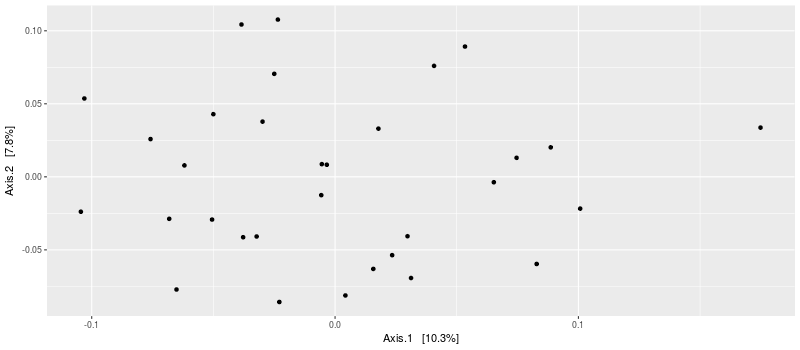

In [13]:
%%R -w 800 -h 350
pcoa = ordinate(phy.st, 
                method = "PCoA", 
                distance = bray.dist)
plot_ordination(phy.st, pcoa) %>% print
p.df = plot_ordination(phy.st, pcoa, justDF = TRUE)

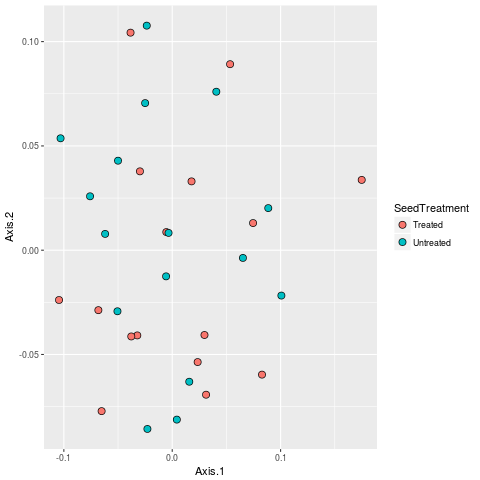

In [14]:
%%R
## generating plots
p1 = ggplot(p.df, aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(fill=SeedTreatment), pch = 21, size = 3)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

# Adonis testing treatment effects

In [15]:
%%R
set.seed(101)

df = as(sample_data(phy.st), "data.frame")
d = bray.dist
#df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Genotype*SeedTreatment, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Genotype * SeedTreatment, data = df,      permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                       Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep                     3   0.19504 0.065014 1.80409 0.16148  0.001 ***
Genotype                3   0.11583 0.038611 1.07141 0.09590  0.208    
SeedTreatment           1   0.03695 0.036949 1.02530 0.03059  0.351    
Genotype:SeedTreatment  3   0.10325 0.034416 0.95501 0.08548  0.673    
Residuals              21   0.75678 0.036037         0.62655           
Total                  31   1.20785                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R
ordMean = p.df %>% 
    group_by(Genotype, R_Year, SeedTreatment) %>%
    summarize(mAxis.1 = mean(Axis.1),
                seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1)),
             mAxis.2 = mean(Axis.2), 
             seAxis.2 = sd(Axis.2)/sqrt(length(Axis.2)))

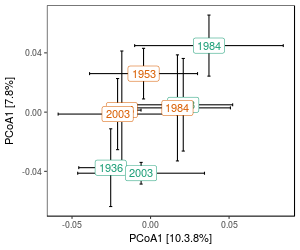

In [17]:
%%R -w 300 -h 250
p1 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year, color = SeedTreatment)) +
    geom_point()+
    theme_pub()+
    scale_color_manual(values = TreatmentColors)+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = SeedTreatment)) +
    theme(legend.position = "none")+
    xlab("PCoA1 [10.3%]")+
    ylab("PCoA1 [7.8%]")
p1

In [21]:
%%R
svg(filename = '/home/bryan/ERA/data/figures/ms_versions/SeedTreatment_BCC.svg', width = 3.14, height = 3.14)
print(p1)
dev.off()

png 
  2 


In [19]:
%%R
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2         dplyr_0.5.0               
 [3] lsmeans_2.25-5             estimability_1.2          
 [5] lmerTest_2.0-33            lme4_1.1-13               
 [7] Matrix_1.2-10              phyloseq_1.19.1           
 [9] DESeq2_1.14.1              SummarizedExperiment_1.4.0
[11] Biobase_2.34.0             GenomicRanges_1.26.4      
[13] GenomeInfoDb_1.